In [1]:
import json
import pickle
import os
import os.path as osp
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from jax import vmap
import pyvista as pv
import numpy as np
from jax_md.partition import space
import matplotlib.pyplot as plt

from neural_sph.utils import case_setup_redist, rho_computer

plt.rcParams.update({'font.size': 14})

os.makedirs("rlt/figs", exist_ok=True)

2024-07-05 00:45:40.669356: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:273] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def plot_hist(
    dirs,
    rlt_dir,
    metadata_root,
    labels=None,
    time_steps=[-1, 10, 20, 50],
    input_seq_len=6,
    targets=["vel_mag", "acc_mag"],
    average_over_n_rollouts=5,
    verbose=False,
    num_bins=100,
    save_name=None,
    time_steps_plot=None,
    xlims=None,  # if not none, expects [[xmin_left, xmax_left], [xmin_right, ymax_right]]
    is_lenend_everywhere=False,
):
    """Plot the historgram of properties at particular steps.

    Args:
        dirs (List[int]): list of `test{str(dir)}` directories to plot from.
        rlt_dir (str): directory containing all experiments of this type
        metadata_root (str): dataset directory.
        labels (List[str], optional): labels for the legend. Defaults to None.
        time_steps (list, optional): steps to plot. Defaults to [-1, 10, 20, 50].
        input_seq_len (int, optional): as during traiinig. Defaults to 6.
        targets (list, optional): Stats type. Defaults to ["vel_mag", "acc_mag"].
        average_over_n_rollouts (int, optional): num rollouts to use. Defaults to 5.
    """

    assert len(targets) == 2, "only two targets are supported"
    targets_choices = ["num_nbrs", "dist_nbrs", "vel_mag", "acc_mag"]
    assert targets[0] in targets_choices, f"targets must be one of {targets_choices}"
    assert targets[1] in targets_choices, f"targets must be one of {targets_choices}"

    c = ["k", "r", "g", "b", "c", "m", "y", "orange", "brown", "pink", "silver"]
    title_dict = {
        "num_nbrs": "Number of neighbors",
        "dist_nbrs": "Distance between neighbors",
        "vel_mag": "Velocity magnitudes",
        "acc_mag": "Acceleration magnitudes",
    }
    target_dict = {targets[0]: 0, targets[1]: 1}
    metadata, _, displacement_fn, _, nbrs_update, _, _ = case_setup_redist(
        metadata_root, is_physical=True, verbose=verbose
    )

    dt = metadata["dt"]
    N = metadata["num_particles_max"]

    displacement_fn_set = vmap(displacement_fn, in_axes=(0, 0))

    def v_fn(r1, r0):
        # r has a shape of (N, D)
        vels = displacement_fn_set(r1, r0) / dt / metadata["write_every"]
        return vels

    # compute averages for each step and dir over M rollouts
    metrics_dict = {}
    for step in time_steps:  # for each step along the rollout
        metrics_dict[step] = {}  # for each step
        for dir in dirs:  # for each dir in dirs
            metrics_dict[step][dir] = {targets[0]: None, targets[1]: None}

    for k, step in enumerate(time_steps):
        for j, d in enumerate(dirs):
            metrics_dict_sub = {targets[0]: [], targets[1]: []}

            for i in range(average_over_n_rollouts):
                rollout = pickle.load(
                    open(osp.join(rlt_dir, f"test{d}/rollout_{i}.pkl"), "rb")
                )

                r = rollout["predicted_rollout"][step + input_seq_len - 1]

                if "nbrs" in targets[0] or "nbrs" in targets[1]:
                    nbrs = nbrs_update(r)
                    edges = nbrs.idx

                r = r[rollout["particle_type"] == 0]  # only fluid particles

                if "num_nbrs" in targets:
                    # mask out padding edges
                    mask = edges != N
                    existing_edges = edges[:, mask[0]]

                    # plot histogram of number of neighbors per particle
                    # counts is a list of shape (N,) with integer numbers
                    _, counts = np.unique(existing_edges[1], return_counts=True)
                    metrics_dict_sub["num_nbrs"].append(counts)

                if "dist_nbrs" in targets:
                    # plot histogram of distances between connected particles
                    i_s, j_s = nbrs.idx
                    r_i_s, r_j_s = r[i_s], r[j_s]
                    dr_i_j = vmap(displacement_fn)(r_i_s, r_j_s)
                    dist = space.distance(dr_i_j)
                    dist = dist[dist > 0.000001]  # ignore self-connections
                    # # dist /= nbrs.cell_size  # normalize distance to [0, 1]
                    metrics_dict_sub["dist_nbrs"].append(dist)

                if "vel_mag" in targets or "acc_mag" in targets:
                    # plot histogram of velocity magnitudes
                    r_prev = rollout["predicted_rollout"][step + input_seq_len - 2]
                    r_prev = r_prev[rollout["particle_type"] == 0]
                    vel = v_fn(r, r_prev)
                    vel_mag = np.linalg.norm(vel, axis=-1)
                    metrics_dict_sub["vel_mag"].append(vel_mag)

                if "acc_mag" in targets:
                    # if we want the acceleration, we can do this:
                    r_next = rollout["predicted_rollout"][step + input_seq_len]
                    r_next = r_next[rollout["particle_type"] == 0]
                    vel_next = v_fn(r_next, r)
                    acc = (vel_next - vel) / dt / metadata["write_every"]
                    acc_mag = np.linalg.norm(acc, axis=-1)
                    metrics_dict_sub["acc_mag"].append(acc_mag)

            metrics_dict[step][d] = {
                targets[0]: np.concatenate(metrics_dict_sub[targets[0]], axis=0),
                targets[1]: np.concatenate(metrics_dict_sub[targets[1]], axis=0),
            }

    # plot a row for each time step
    fig, axs = plt.subplots(
        len(time_steps),
        2,
        figsize=(15, 3 * len(time_steps)),
        sharex="col",
        sharey="col",
    )
    for j, d in enumerate(dirs):
        label = labels[j] if labels is not None else d

        for i, step in enumerate(time_steps):
            if "num_nbrs" in targets:
                # plot histogram of number of neighbors per particle
                counts = metrics_dict[step][d]["num_nbrs"]
                values, counts = np.unique(counts, return_counts=True)
                bins = np.arange(values[0], values[-1] + 2) - 0.5
                idx = target_dict["num_nbrs"]
                axs[i, idx].hist(
                    values,
                    bins=bins,
                    weights=counts,
                    density=True,
                    histtype="step",
                    label=label,
                    color=c[j],
                )

            if "dist_nbrs" in targets:
                # plot histogram of distances between connected particles
                dist = metrics_dict[step][d]["dist_nbrs"]
                idx = target_dict["dist_nbrs"]
                axs[i, idx].hist(
                    dist,
                    bins=num_bins,
                    density=True,
                    histtype="step",
                    label=label,
                    color=c[j],
                )

            if "vel_mag" in targets:
                # plot histogram of velocity magnitudes
                vel_mag = metrics_dict[step][d]["vel_mag"]
                idx = target_dict["vel_mag"]
                axs[i, idx].hist(
                    vel_mag,
                    bins=num_bins,
                    density=True,
                    histtype="step",
                    label=label,
                    color=c[j],
                )

            if "acc_mag" in targets:
                # plot histogram of acceleration magnitudes
                acc_mag = metrics_dict[step][d]["acc_mag"]
                idx = target_dict["acc_mag"]
                axs[i, idx].hist(
                    acc_mag,
                    bins=num_bins,
                    density=True,
                    histtype="step",
                    label=label,
                    color=c[j],
                )

    # axs[0, 0].set_title(title_dict[targets[0]])
    # axs[0, 1].set_title(title_dict[targets[1]])
    axs[-1, 0].set_xlabel(title_dict[targets[0]])
    axs[-1, 1].set_xlabel(title_dict[targets[1]])
    if is_lenend_everywhere:
        for i in range(len(time_steps)):
            axs[i, 0].legend(loc="upper left")
            axs[i, 1].legend(loc="upper right")
    else:
        axs[0, 0].legend(loc="upper left")
    
    if xlims is not None:
        for i in range(len(time_steps)):
            axs[i, 0].set_xlim(xlims[0])
            axs[i, 1].set_xlim(xlims[1])

    if time_steps_plot is not None:
        time_steps = time_steps_plot
    for i, step in enumerate(time_steps):
        axs[i, 0].set_ylabel(f"step {step}")

    for ax in axs.flatten():
        ax.grid()

    plt.tight_layout()
    
    if save_name is not None:
        plt.savefig(save_name)


In [3]:
with open("/home/atoshev/data/2D_LDC_2708_10kevery100/metadata.json", "r") as f:
    metadata = json.loads(f.read())

step = 400
for path, suffix in zip([
    f"rlt/ldc2d/test100_vtk/rollout_0_ref_{step+5}.vtk",
    f"rlt/ldc2d/test100_vtk/rollout_0_{step+5}.vtk",
    f"rlt/ldc2d/test102_vtk/rollout_0_{step+5}.vtk",
    ], ["ref", "gns", "sphgnn"]
):
    pv_dataset = pv.read(path)
    r = np.array(pv_dataset.points)
    v = np.array(pv_dataset.point_data["v"])
    v = np.sqrt(v[:,0]**2 + v[:,1]**2)
    v /= metadata["dt"] * metadata["write_every"]

    # cmap in ["hsv","cividis", "plasma", "plasma", "cool", "rainbow", "jet", "turbo", "winter", "viridis", "coolwarm"]:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(r[:, 0], r[:, 1], vmin=0.0, vmax=1.0, c=v, cmap="turbo", s=20)
    ax.set_xlim(metadata["bounds"][0])
    ax.set_ylim(metadata["bounds"][1])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid()
    # add colorbar underneath the image
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.2)
    cax = fig.add_axes([0.11, 0.15, 0.78, 0.03])
    cbar = fig.colorbar(ax.collections[0], cax=cax, orientation='horizontal', ticks=[0.0, 0.5, 1])
    cbar.ax.tick_params(labelsize=30, length=12, width=3, )
    fig.savefig(f"rlt/figs/ldc2d_400_v_{suffix}.pdf")
    plt.close()
    
    rho = np.array(pv_dataset.point_data["rho"])
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(r[:, 0], r[:, 1], vmin=0.98, vmax=1.3, c=rho, cmap="turbo", s=20)
    ax.set_xlim(metadata["bounds"][0])
    ax.set_ylim(metadata["bounds"][1])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid()
    # add colorbar underneath the image
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.2)
    cax = fig.add_axes([0.11, 0.15, 0.78, 0.03])
    cbar=fig.colorbar(ax.collections[0], cax=cax, orientation='horizontal', ticks=[1.0, 1.1, 1.2, 1.3])
    cbar.ax.tick_params(labelsize=30, length=12, width=3, )
    # ax.set_xticklabels( [0, 0.5, 1.0] , fontsize=14)
    fig.savefig(f"rlt/figs/ldc2d_400_rho_{suffix}.pdf")
    plt.close()


In [4]:
with open("/home/atoshev/data/2D_DAM_5740_20kevery100/metadata.json", "r") as f:
    metadata = json.loads(f.read())

for idx in range(1):
    for step in [80,]:  # 80, 240
        for path, suffix in zip([
            f"rlt/dam2d/test100_vtk/rollout_{idx}_ref_{step+5}.vtk",
            f"rlt/dam2d/test100_vtk/rollout_{idx}_{step+5}.vtk", # 13 and 16 explode
            f"rlt/dam2d/test101_vtk/rollout_{idx}_{step+5}.vtk",
            # f"rlt/dam2d/test103_vtk/rollout_{idx}_{step+5}.vtk",  # rl1
            f"rlt/dam2d/test113_vtk/rollout_{idx}_{step+5}.vtk",  # rl3
            # f"rlt/dam2d/test115_vtk/rollout_{idx}_{step+5}.vtk",  # rl5
            # f"rlt/dam2d/test116_vtk/rollout_{idx}_{step+5}.vtk",  # rl2
        ], [
            "ref", 
            "gns", 
            "sphgnn-g", 
            # "sphgnn",
            "sphgnn-3",
            # "sphgnn-5",
            # "sphgnn-2",
        ]):
            pv_dataset = pv.read(path)
            r = np.array(pv_dataset.points)
            
            # cmap in ["hsv","cividis", "plasma", "plasma", "cool", "rainbow", "jet", "turbo", "winter", "viridis", "coolwarm"]:
            rho = np.array(pv_dataset.point_data["rho"])
            fig, ax = plt.subplots(figsize=(30, 6))
            ax.scatter(r[:, 0], r[:, 1], vmin=0.98, vmax=1.3, c=rho, cmap="turbo", s=20)
            ax.set_xlim(metadata["bounds"][0])
            ax.set_ylim([0, 1.1])
            ax.set_aspect('equal')
            ax.set_xticks([0, 1, 2, 3, 4, 5])
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid()
            # add colorbar on the right of the image
            fig.tight_layout()
            fig.subplots_adjust(right=0.92) 
            #  (left, bottom, width, height) as fractions of figure width and height
            cax = fig.add_axes([0.93, 0.07, 0.01, 0.86])
            cbar=fig.colorbar(ax.collections[0], cax=cax, orientation='vertical', ticks=[1.0, 1.1, 1.2, 1.3])
            cbar.ax.tick_params(labelsize=50, length=20, width=5, )
            # fig.savefig(f"rlt/figs/dam/dam2d_{step}_rho_{suffix}_{idx}.pdf")
            fig.savefig(f"rlt/figs/dam2d_{step}_rho_{suffix}_{idx}.pdf", dpi=50)
            plt.close()


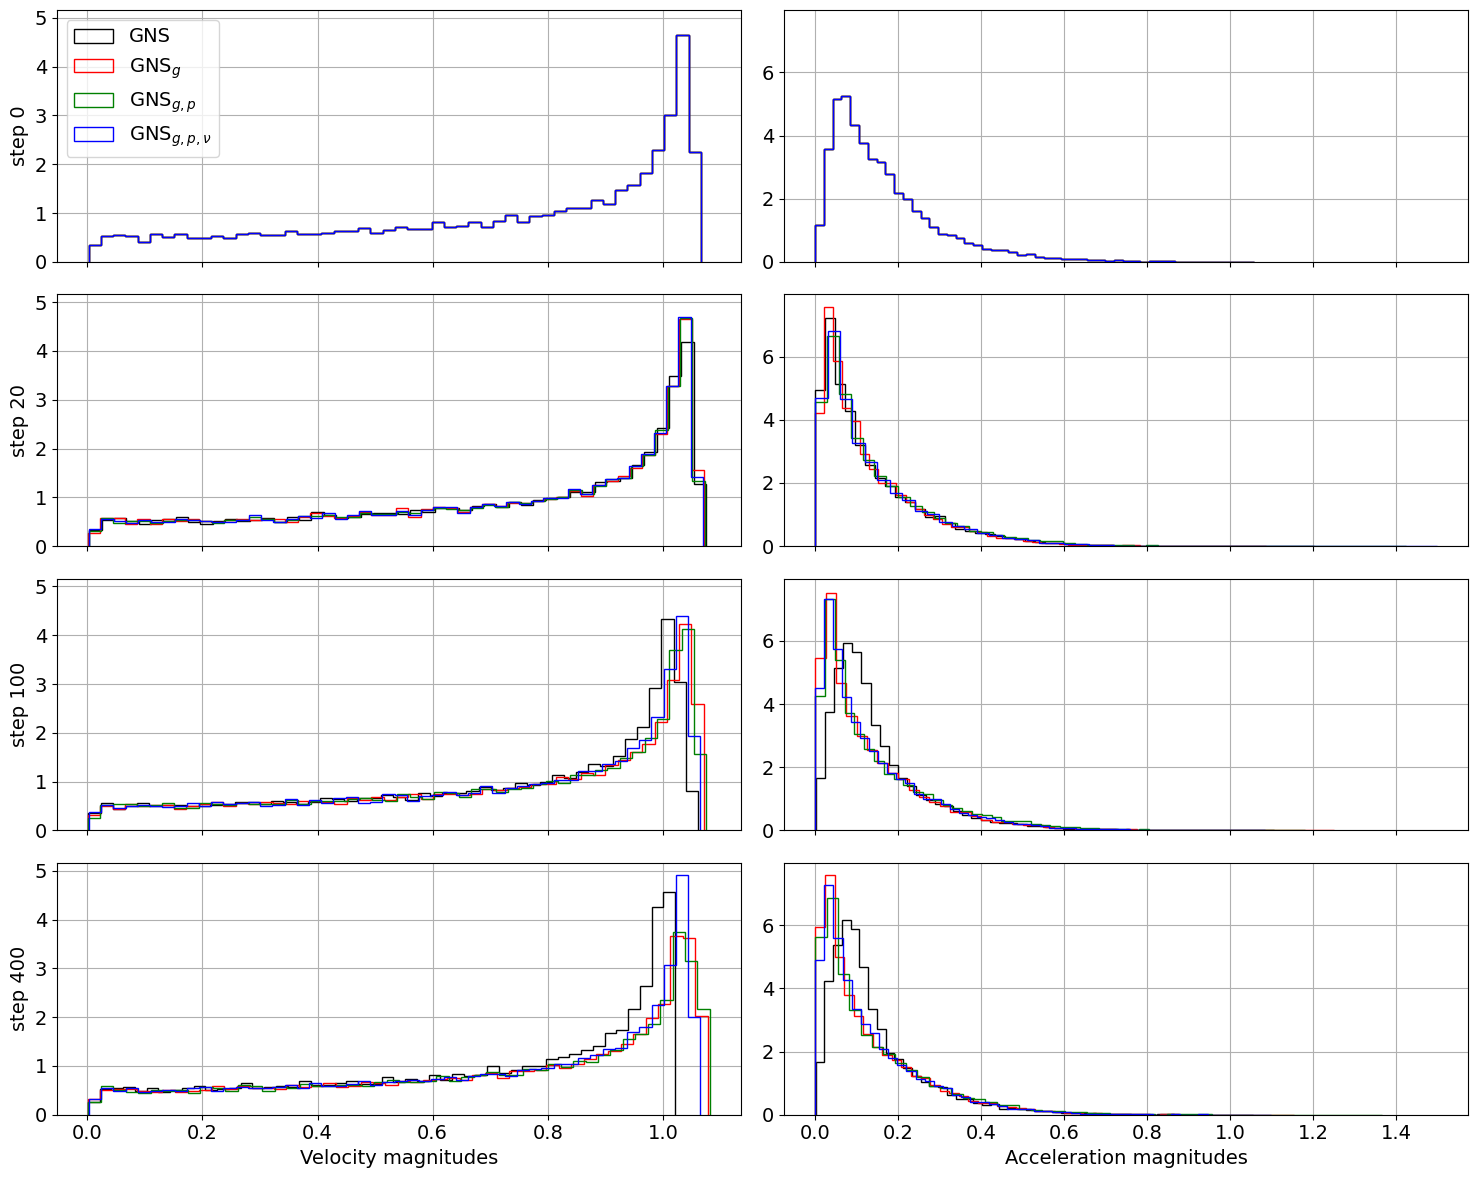

In [5]:
plt.rcParams.update({'font.size': 14})
    
plot_hist(
    dirs=np.array([400, 502, 521, 531]), 
    rlt_dir="rlt/rpf2d", 
    metadata_root="/home/atoshev/data/2D_RPF_3200_20kevery100", 
    targets = ["vel_mag", "acc_mag"], 
    time_steps=[-1, 20, 100, 399], 
    labels=["GNS", r"GNS$_g$", r"GNS$_{g,p}$", r"GNS$_{g,p,\nu}$"],  # rl3ra002-gext2
    num_bins=50,
    save_name=f"rlt/figs/rpf2d_hist.png",
    time_steps_plot=[0, 20, 100, 400]
)

# plot_hist(
#     dirs=np.array([400,]), 
#     rlt_dir="rlt/rpf2d", 
#     metadata_root="/home/atoshev/data/2D_RPF_3200_20kevery100", 
#     targets = ["vel_mag", "acc_mag"], 
#     time_steps=[-1, 399], 
#     labels=["SPH"],  # rl3ra002-gext2
#     num_bins=50,
#     save_name=f"rlt/figs/rpf2d_hist_min1.png",
#     time_steps_plot=[0, 400],
#     xlims=[[0.7, 1.1], [-0.1, 1.4]],
#     is_lenend_everywhere=True
# )

# plot_hist(
#     dirs=np.array([400, 502, 521, 531]), 
#     rlt_dir="rlt/rpf2d", 
#     metadata_root="/home/atoshev/data/2D_RPF_3200_20kevery100", 
#     targets = ["vel_mag", "acc_mag"], 
#     time_steps=[-1, 399], 
#     labels=["GNS", r"GNS$_g$", r"GNS$_{g,p}$", r"GNS$_{g,p,\nu}$"],  # rl3ra002-gext2
#     num_bins=50,
#     save_name=f"rlt/figs/rpf2d_hist_min2.png",
#     time_steps_plot=[0, 400],
#     xlims=[[0.7, 1.1], [-0.1, 1.4]],
#     is_lenend_everywhere=True
# )

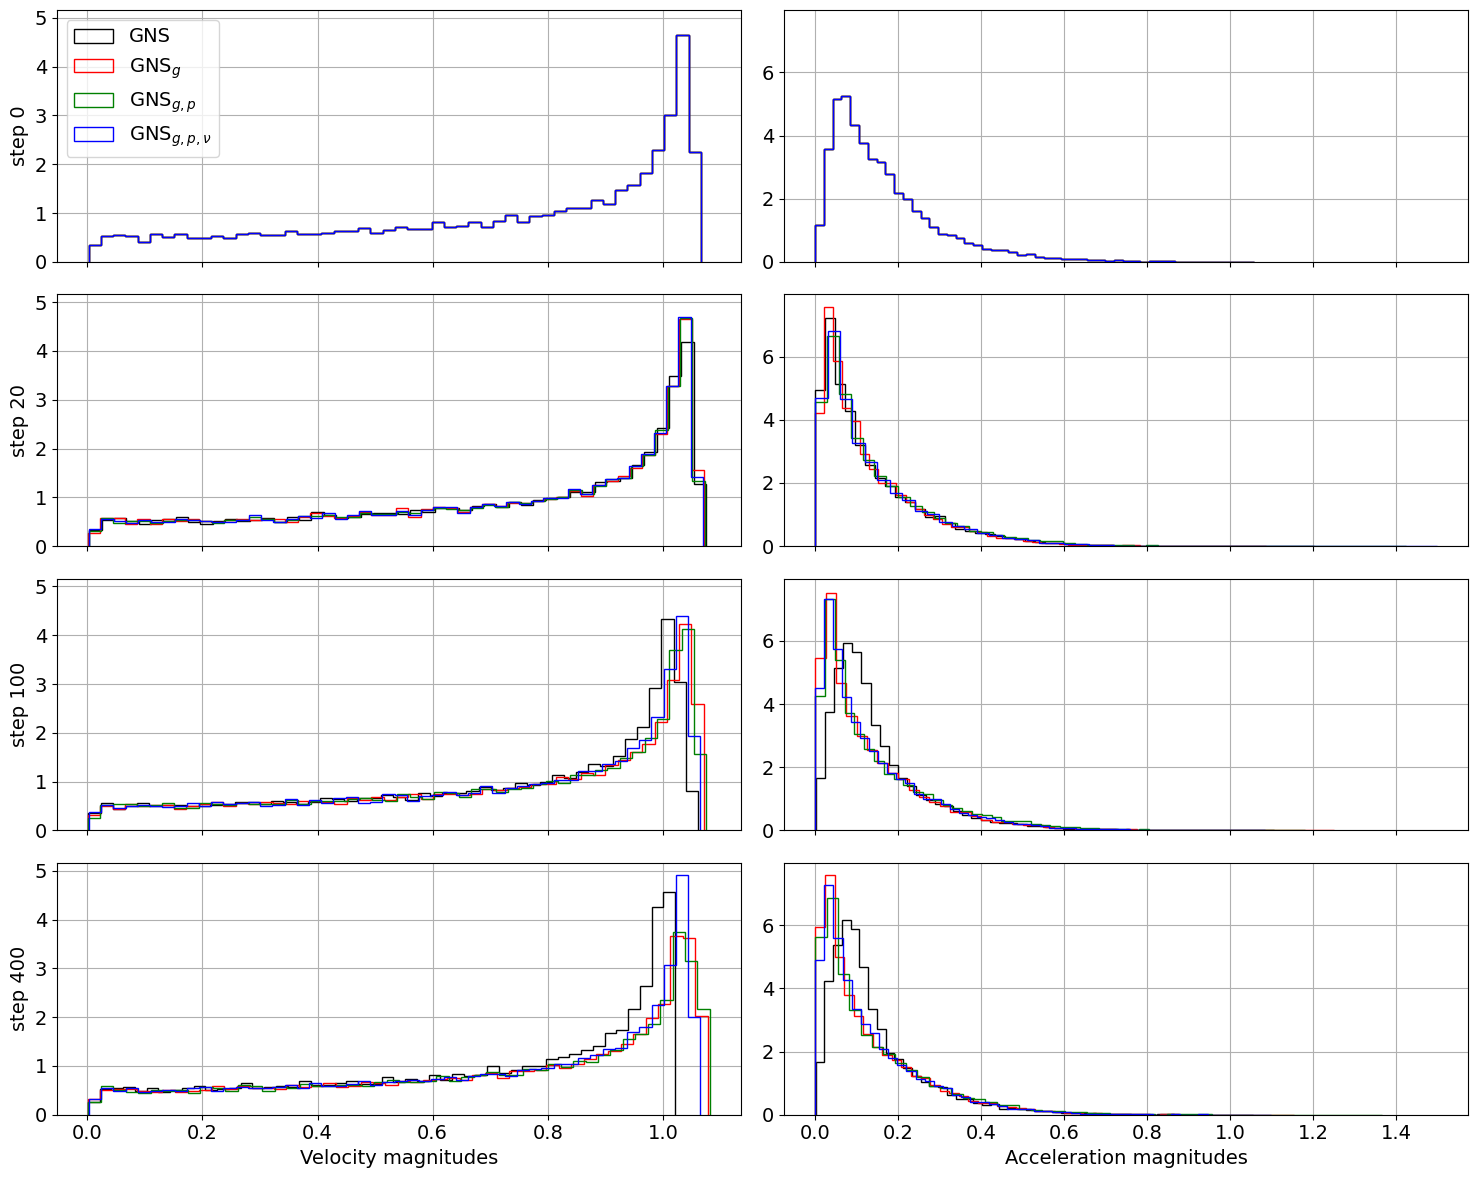

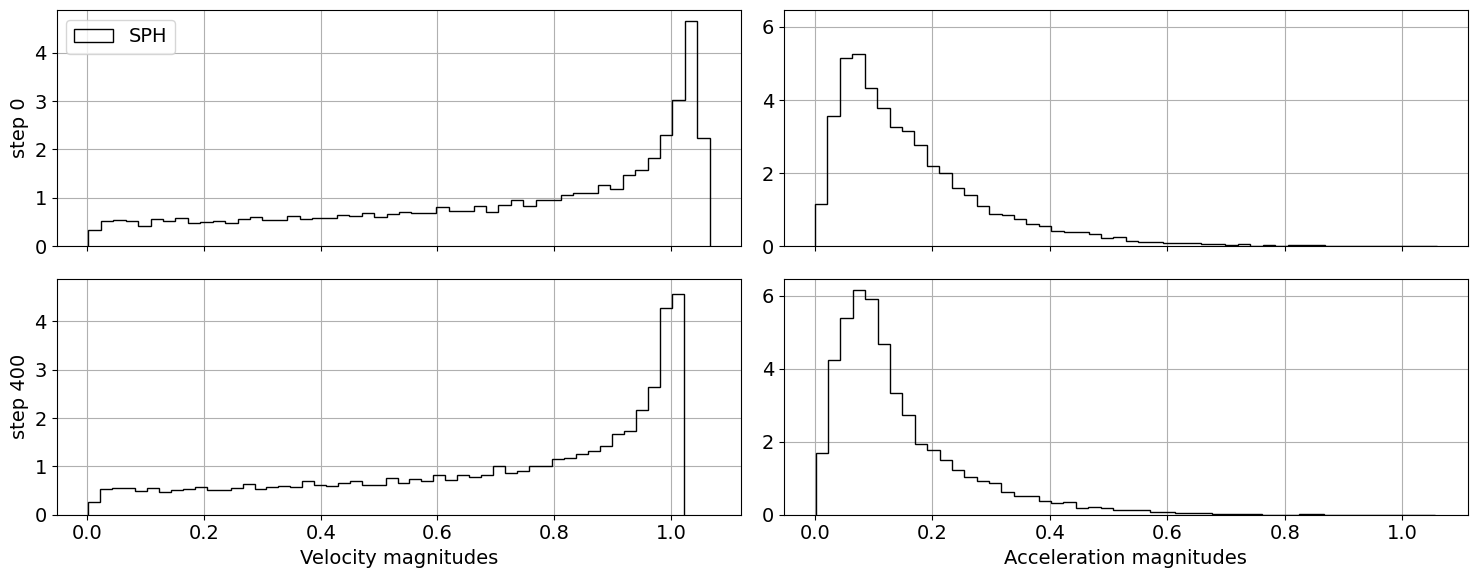

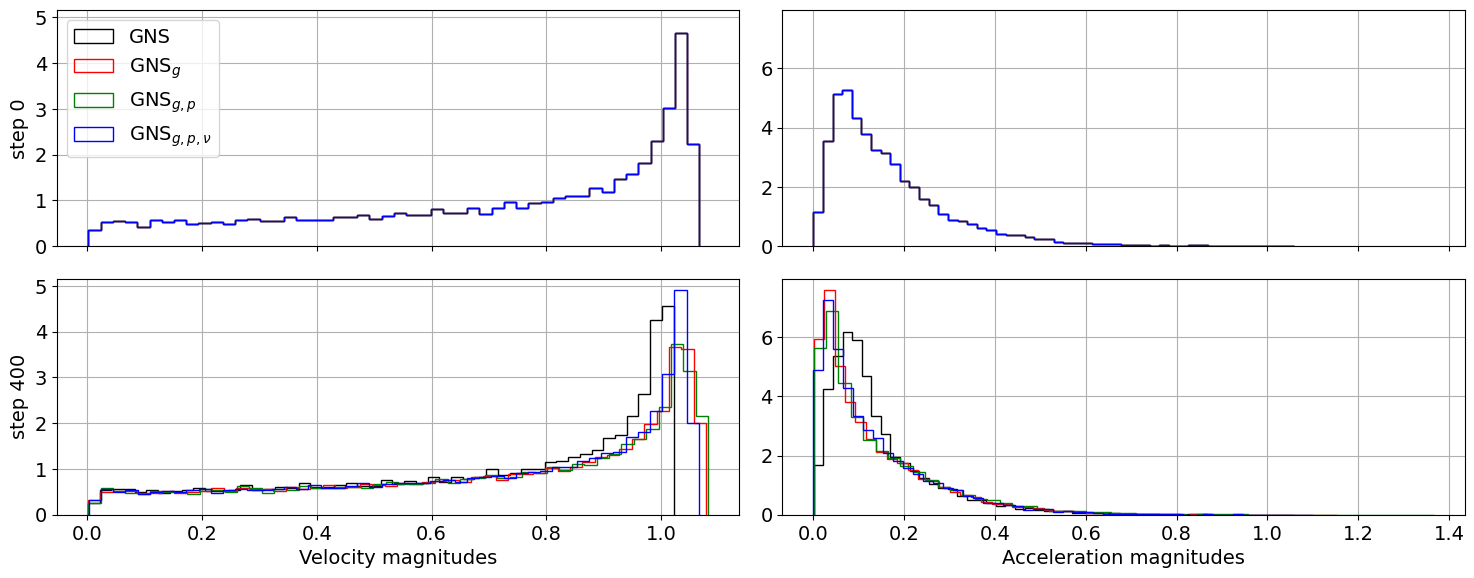

In [6]:

# for time_steps, suffix, time_steps_plot in zip(
#     [[-1, 20, 100, 399], [-1], [399]], 
#     ["", "_min1", "_min2"],
#     [[0, 20, 100, 400], [0], [400]],
#     ):
    
plot_hist(
    dirs=np.array([400, 502, 521, 531]), 
    rlt_dir="rlt/rpf2d", 
    metadata_root="/home/atoshev/data/2D_RPF_3200_20kevery100", 
    targets = ["vel_mag", "acc_mag"], 
    time_steps=[-1, 20, 100, 399], 
    labels=["GNS", r"GNS$_g$", r"GNS$_{g,p}$", r"GNS$_{g,p,\nu}$"],  # rl3ra002-gext2
    num_bins=50,
    save_name=f"rlt/figs/rpf2d_hist.pdf",
    time_steps_plot=[0, 20, 100, 400]
)

plot_hist(
    dirs=np.array([400]), 
    rlt_dir="rlt/rpf2d", 
    metadata_root="/home/atoshev/data/2D_RPF_3200_20kevery100", 
    targets = ["vel_mag", "acc_mag"], 
    time_steps=[-1, 399], 
    labels=["SPH"],  # rl3ra002-gext2
    num_bins=50,
    save_name=f"rlt/figs/rpf2d_hist_min1.pdf",
    time_steps_plot=[0,400]
)

plot_hist(
    dirs=np.array([400, 502, 521, 531]), 
    rlt_dir="rlt/rpf2d", 
    metadata_root="/home/atoshev/data/2D_RPF_3200_20kevery100", 
    targets = ["vel_mag", "acc_mag"], 
    time_steps=[-1, 399], 
    labels=["GNS", r"GNS$_g$", r"GNS$_{g,p}$", r"GNS$_{g,p,\nu}$"],  # rl3ra002-gext2
    num_bins=50,
    save_name=f"rlt/figs/rpf2d_hist_min2.pdf",
    time_steps_plot=[0,400]
)

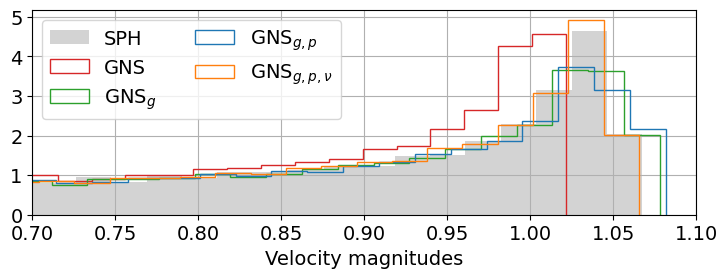

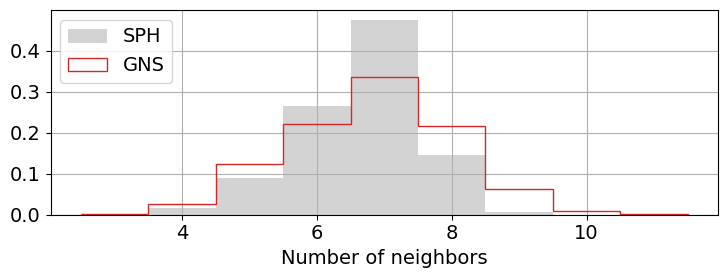

In [7]:
# plot for main paper

def plot_hist_paper(
    dirs,
    rlt_dir,
    metadata_root,
    labels=None,
    time_steps=[-1, 399, 399, 399, 399],
    input_seq_len=6,
    targets=["vel_mag"],
    average_over_n_rollouts=5,
    verbose=False,
    num_bins=100,
    save_name=None,
    xlims=None,  # if not none, expects [[xmin_left, xmax_left], [xmin_right, ymax_right]]
    yticks=None,
    ncol=1,
):
    """Plot the historgram of properties at particular steps.

    Args:
        dirs (List[int]): list of `test{str(dir)}` directories to plot from.
        rlt_dir (str): directory containing all experiments of this type
        metadata_root (str): dataset directory.
        labels (List[str], optional): labels for the legend. Defaults to None.
        time_steps (list, optional): steps to plot. Defaults to [-1, 10, 20, 50].
        input_seq_len (int, optional): as during traiinig. Defaults to 6.
        targets (list, optional): Stats type. Defaults to ["vel_mag", "acc_mag"].
        average_over_n_rollouts (int, optional): num rollouts to use. Defaults to 5.
    """

    assert len(targets) == 1, "only one targets are supported"
    targets_choices = ["num_nbrs", "dist_nbrs", "vel_mag", "acc_mag"]
    assert targets[0] in targets_choices, f"targets must be one of {targets_choices}"

    # c = ["lightgray", "r", "g", "b", "c", "m", "y", "orange", "brown", "pink", "silver"]
    c = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    c = ["lightgray", c[3], c[2], c[0], c[1]]
    title_dict = {
        "num_nbrs": "Number of neighbors",
        "dist_nbrs": "Distance between neighbors",
        "vel_mag": "Velocity magnitudes",
        "acc_mag": "Acceleration magnitudes",
    }
    target_dict = {targets[0]: 0}
    metadata, _, displacement_fn, _, nbrs_update, _, _ = case_setup_redist(
        metadata_root, is_physical=True, verbose=verbose
    )

    dt = metadata["dt"]
    N = metadata["num_particles_max"]

    displacement_fn_set = vmap(displacement_fn, in_axes=(0, 0))

    def v_fn(r1, r0):
        # r has a shape of (N, D)
        vels = displacement_fn_set(r1, r0) / dt / metadata["write_every"]
        return vels

    # compute averages for each step and dir over M rollouts
    metrics_dict = {}
    for step in time_steps:  # for each step along the rollout
        metrics_dict[step] = {}  # for each step
        for dir in dirs:  # for each dir in dirs
            metrics_dict[step][dir] = {targets[0]: None}

    for j, (d, step) in enumerate(zip(dirs, time_steps)):
        metrics_dict_sub = {targets[0]: []}

        for i in range(average_over_n_rollouts):
            rollout = pickle.load(
                open(osp.join(rlt_dir, f"test{d}/rollout_{i}.pkl"), "rb")
            )

            r = rollout["predicted_rollout"][step + input_seq_len - 1]

            if "nbrs" in targets[0]:
                nbrs = nbrs_update(r)
                edges = nbrs.idx

            r = r[rollout["particle_type"] == 0]  # only fluid particles

            if "num_nbrs" in targets:
                # mask out padding edges
                mask = edges != N
                existing_edges = edges[:, mask[0]]

                # plot histogram of number of neighbors per particle
                # counts is a list of shape (N,) with integer numbers
                _, counts = np.unique(existing_edges[1], return_counts=True)
                metrics_dict_sub["num_nbrs"].append(counts)

            if "vel_mag" in targets or "acc_mag" in targets:
                # plot histogram of velocity magnitudes
                r_prev = rollout["predicted_rollout"][step + input_seq_len - 2]
                r_prev = r_prev[rollout["particle_type"] == 0]
                vel = v_fn(r, r_prev)
                vel_mag = np.linalg.norm(vel, axis=-1)
                metrics_dict_sub["vel_mag"].append(vel_mag)

        metrics_dict[step][d] = {
            targets[0]: np.concatenate(metrics_dict_sub[targets[0]], axis=0),
        }

    # plot a row for each time step
    fig, axs = plt.subplots(1, 1, figsize=(7.5, 3))
    for j, (d, step) in enumerate(zip(dirs, time_steps)):
        label = labels[j] if labels is not None else d

        histtype = "stepfilled" if j == 0 else "step"

        if "vel_mag" in targets:
            # plot histogram of velocity magnitudes
            vel_mag = metrics_dict[step][d]["vel_mag"]
            idx = target_dict["vel_mag"]
            # print(vel_mag.shape, num_bins, label, c[j])
            axs.hist(
                vel_mag,
                bins=num_bins,
                density=True,
                histtype=histtype,
                label=label,
                color=c[j],
            )
        if "num_nbrs" in targets:
            # plot histogram of number of neighbors per particle
            counts = metrics_dict[step][d]["num_nbrs"]
            values, counts = np.unique(counts, return_counts=True)
            bins = np.arange(values[0], values[-1] + 2) - 0.5
            idx = target_dict["num_nbrs"]
            axs.hist(
                values,
                bins=bins,
                weights=counts,
                density=True,
                histtype=histtype,
                label=label,
                color=c[j],
            )
    axs.set_xlabel(title_dict[targets[0]])

    axs.legend(loc="upper left", ncols=ncol)

    if xlims is not None:
        axs.set_xlim(xlims[0])
    axs.grid()
    
    if yticks is not None:
        axs.set_yticks(yticks)

    plt.tight_layout()

    if save_name is not None:
        os.makedirs(osp.dirname(save_name), exist_ok=True)
        plt.savefig(save_name)

plt.rcParams.update({'font.size': 14})
plot_hist_paper(
    dirs=np.array([400, 400, 502, 521, 531]), 
    rlt_dir="rlt/rpf2d", 
    metadata_root="/home/atoshev/data/2D_RPF_3200_20kevery100", 
    targets = ["vel_mag"], 
    time_steps=[0, 399, 399, 399, 399], 
    labels=["SPH", "GNS", r"GNS$_g$", r"GNS$_{g,p}$", r"GNS$_{g,p,\nu}$"], 
    num_bins=50,
    xlims=[[0.7, 1.1]],
    save_name=f"rlt/figs/rpf2d_hist_min_paper.pdf",
    yticks=[0, 1, 2, 3, 4, 5],
    ncol=2
)

plot_hist_paper(
    dirs=np.array([100, 100]), 
    rlt_dir="rlt/ldc2d", 
    metadata_root="/home/atoshev/data/2D_LDC_2708_10kevery100", 
    targets = ["num_nbrs"], 
    time_steps=[-1, 399], 
    labels=["SPH", "GNS"],  # rl3ra002-gext2
    num_bins=50,
    save_name=f"rlt/figs/ldc2d_hist_nbrs_paper.pdf",
)